# Preprocessing
## Steps 
1. Basic preprocessing
    1.1. Remove training scene
    1.2. Ensuring 10+ Events
    1.3. Analysis of Delta Time (to ensure no large time differences between samples)
    1.4. Excluding `II_variant`
2. Blink detection to get true blinks
3. Steering input should not be constant zero.
4. Large calibration issues (systematic deviations from mean value).
7. Timestamps issues: (1. loong differences from a ts to the next; 2 repeated rows with likely same info)
8. Sampling rate calculation and resample



In [1]:
import gc
import glob  
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pathos.pools
from functools import partial
import os
import math
from  matplotlib.ticker import PercentFormatter
sns.set_style("white")
# sns.set_context("notebook")
sns.set_theme(style="ticks", palette="husl")
# set dask dashboard
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
from scipy.spatial.transform import Rotation as R
# pd.options.mode.chained_assignment = None  # default='warn'
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49407,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:49418,Total threads: 4
Dashboard: http://127.0.0.1:49419/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:49410,


In [2]:
# Define dtypes to load all uid files
dtypes = {'uid': 'str','dataset': 'str','city_section': 'str','ExperimentalCondition': 'str','EventName': 'object','HitObjectName': 'object','ObjectName_4': 'object','ObjectName_5': 'object', 'EventDuration': 'float64', 'TimeStamp': 'float64'}
# Define the path to the CSV file
# Use the current working directory
dir = os.getcwd()
# Use glob to find all CSV files in the specified directory
data_path = dir + '/Data/'
# file_path = os.path.join(data_folder, file_name)  # Complete path to the file
# load all data
ddf = dd.read_csv(data_path + '*.csv', assume_missing=True, dtype=dtypes, blocksize="100MB", low_memory=False)

In [3]:
ddf

<dask_expr.expr.DataFrame: expr=ReadCSV(c4080fc)>

In [4]:
# Run only if you want (computer memory permits) to load all csv file 
# df = ddf.compute()

In [5]:
# Get unique uids from the 'uid' column and convert to a list
unique_uids = ddf['uid'].drop_duplicates().compute().tolist()
unique_uids

2025-02-20 23:06:13,326 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6f942101d652dcf820a43442b4e86f6b initialized by task ('shuffle-transfer-6f942101d652dcf820a43442b4e86f6b', 51) executed on worker tcp://127.0.0.1:49424
2025-02-20 23:06:15,836 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6f942101d652dcf820a43442b4e86f6b deactivated due to stimulus 'task-finished-1740089175.834358'


['0117810eb9634c4f98f842021ee6a595',
 '2fe73e7e2534479aa59aeb91635906aa',
 '68dee417b7c6402e80e3001a8d07ac53',
 '7c0436814ca14e00bfab565cb89f4039',
 'a5e665fb970b4b03a810698a63b3b635',
 'e113171c2c8c48679e92a0e241b31060',
 '47e5b0cb9fca4c5c9748b9e03e63a9a7',
 '56341d0729234d90ae05458aab4b43c4',
 '6f36a58eb7d843a593a01191c53bc0d0',
 '9d21c3cf1fb64f87a7ee9f6612d31768',
 '40ffa04f4781418c946b01206562b124',
 '806565e397a2453d8287d04d059399de',
 'a7da330198d5442d92f4cb9a3ab49a62',
 '0121f5b2f59d434f8beb17bf3e2a80b9',
 '228bdb9398f6492092c45467428bb95a',
 '27ee7a0bfc2840e38225f653232d1487',
 '677eb13e053d46edb23876a1cf070e34',
 'f820d1c1117c4255a529f527c6c82d1f',
 '8fa9f3c28edc4b2a88556096f09ec8cb',
 '91519bcefe1844d595ff7317c00b0351',
 '8c3f910d2ca947e9abe0cf5786c40ed3',
 'e204e48fbca64ed9a9aa05a213dc8381',
 'f767840dc9b94eeabb8d0cfb2a5da57c',
 '29006bddb3e8430582165c73bc7af864',
 'b7f065b7dbbe442485552fa041d44b20',
 '0ed7464df24848a68bcc2dfd1ec58f29',
 '5b086469856442e8abac0651c33e2c8e',
 

In [6]:
len(unique_uids)

171

## 1. Basic preprocessing
### 1.1 Remove TrainingScene

In [7]:
# Retrieve all data for specific uid and remove TrainingScene
# df = ddf[(ddf['uid'] == unique_uids[0]) & (ddf['city_section'] != 'TrainingScene') & (ddf['EventName'] != 'II_variant')].compute()
# Retrieve all data for all uid, remove TrainingScene
df = ddf[(ddf['city_section'] != 'TrainingScene')].compute()

2025-02-20 23:06:36,351 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 12.34 GiB -- Worker memory limit: 16.00 GiB


In [8]:
# Count the amount of unique of Events per uid
complete_events = df.groupby('uid')['EventName'].nunique().sort_values(ascending=True)
complete_events

uid
4a10fec1583843e5b1c82fb74fa7c775     7
b89680ab48514db8bca8fcca1852f36d     8
eadeee63de7f40a4b4375733651d5dd1     9
ccb6fbce179d456c892ce2e029dd7fd1     9
8e03eb1671774d3d9a35f97178902a45     9
                                    ..
7736a53b63874dde915148a2f4f4a753    12
7b1f3e040a654bb7afff67a711e46081    12
7c0436814ca14e00bfab565cb89f4039    12
a710f3de91aa4ab1855aea34eb52a03e    12
ff4288f304e74bbf93aa6508c7df8145    12
Name: EventName, Length: 171, dtype: int64

### 1.2 Ensuring 10+ Events 

In [9]:
# Filter out groups with less than 11 unique events
valid_uids = complete_events[complete_events >= 10].index.to_list()
# Filter the original DataFrame based on valid uids
filtered_df = df[df['uid'].isin(valid_uids)]
filtered_df.head(10)

,timestamp_REF,uid,dataset,city_section,ExperimentalCondition,UnixTimeStamp,TobiiTimeStamp,FPS,RightEyeIsBlinkingWorld,RightEyeIsBlinkingLocal,...,EndOfEventTimeStamp,EventDuration,SuccessfulCompletionState,HitObjectName,TimeStamp,ReceivedInput,SteeringInput,AcellerationInput,BrakeInput,TimeStamp_in_sec
5237,2020-09-26 13:46:07.387864320+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,320.263977,90.002266,False,False,...,NaN,NaN,NaN,NaN,1.601128e+09,True,-0.063991,0.0,0.0,124.885496
5238,2020-09-26 13:46:10.404847616+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,336.057007,3.215231,False,False,...,NaN,NaN,NaN,NaN,1.601128e+09,True,-0.012914,0.0,0.0,127.902479
5239,2020-09-26 13:46:10.415003904+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,336.071259,3.554384,False,False,...,NaN,NaN,NaN,NaN,1.601128e+09,True,-0.012914,0.0,0.0,127.912636
5240,2020-09-26 13:46:10.432984064+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,336.089417,3.921189,False,False,...,NaN,NaN,NaN,NaN,1.601128e+09,True,-0.012914,0.0,0.0,127.930616
5241,2020-09-26 13:46:10.444952320+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,336.101135,4.334725,False,False,...,NaN,NaN,NaN,NaN,1.601128e+09,True,-0.012914,0.0,0.0,127.942584
5242,2020-09-26 13:46:10.467023104+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,336.122864,5.292978,False,False,...,NaN,NaN,NaN,NaN,1.601128e+09,True,-0.012914,0.0,0.0,127.964655
5243,2020-09-26 13:46:10.477894144+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,336.134216,5.842119,False,False,...,NaN,NaN,NaN,NaN,1.601128e+09,True,-0.012914,0.0,0.0,127.975526
5244,2020-09-26 13:46:10.490250240+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,336.145996,6.441910,False,False,...,NaN,NaN,NaN,NaN,1.601128e+09,True,-0.012914,0.0,0.0,127.987882
5245,2020-09-26 13:46:10.500556800+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,336.157440,7.099532,False,False,...,NaN,NaN,NaN,NaN,1.601128e+09,True,-0.012914,0.0,0.0,127.998189
5246,2020-09-26 13:46:10.522168576+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,336.178619,8.612434,False,False,...,NaN,NaN,NaN,NaN,1.601128e+09,True,-0.012914,0.0,0.0,128.019800


### 1.3 Analysis of Delta Time 
We calculate the delta time between datapoints to detect possible data loss or sampling rate issues.

In [10]:
# Since NaN in "EventName" represent moments outside events, we replace them with "OutsideEvent"
filtered_df['EventName'] = filtered_df['EventName'].fillna('NoEvent')
# Group by 'uid' and calculate the difference for 'TimeStamp_in_sec'
filtered_df['TimeDiff_in_sec'] = filtered_df.groupby('uid')['TimeStamp_in_sec'].diff()

In [11]:
filtered_df

,timestamp_REF,uid,dataset,city_section,ExperimentalCondition,UnixTimeStamp,TobiiTimeStamp,FPS,RightEyeIsBlinkingWorld,RightEyeIsBlinkingLocal,...,EventDuration,SuccessfulCompletionState,HitObjectName,TimeStamp,ReceivedInput,SteeringInput,AcellerationInput,BrakeInput,TimeStamp_in_sec,TimeDiff_in_sec
5237,2020-09-26 13:46:07.387864320+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,320.263977,90.002266,False,False,...,NaN,NaN,NaN,1.601128e+09,True,-0.063991,0.0,0.0,124.885496,NaN
5238,2020-09-26 13:46:10.404847616+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,336.057007,3.215231,False,False,...,NaN,NaN,NaN,1.601128e+09,True,-0.012914,0.0,0.0,127.902479,3.016983
5239,2020-09-26 13:46:10.415003904+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,336.071259,3.554384,False,False,...,NaN,NaN,NaN,1.601128e+09,True,-0.012914,0.0,0.0,127.912636,0.010156
5240,2020-09-26 13:46:10.432984064+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,336.089417,3.921189,False,False,...,NaN,NaN,NaN,1.601128e+09,True,-0.012914,0.0,0.0,127.930616,0.017980
5241,2020-09-26 13:46:10.444952320+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,336.101135,4.334725,False,False,...,NaN,NaN,NaN,1.601128e+09,True,-0.012914,0.0,0.0,127.942584,0.011968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100077,2020-09-19 10:31:35.095044608+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.914185,90.083817,False,False,...,NaN,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.316932,0.021942
100078,2020-09-19 10:31:35.116986112+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.936523,89.880363,False,False,...,NaN,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.338873,0.021942
100079,2020-09-19 10:31:35.139722752+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.958374,90.203796,False,False,...,NaN,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.361610,0.022737
100080,2020-09-19 10:31:35.150694400+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.969727,89.948059,False,False,...,NaN,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.372582,0.010972


Visualize delta times per uid across time

In [13]:
# Function to save plots for UIDs in batches
def plot_uids_in_batches(filtered_df, batch_size=10):
    unique_uids = filtered_df['uid'].unique()
    num_batches = (len(unique_uids) + batch_size - 1) // batch_size

    for i in range(num_batches):
        batch_uids = unique_uids[i * batch_size:(i + 1) * batch_size]
        
        # Create a DataFrame for the current batch
        batch_df = filtered_df[filtered_df['uid'].isin(batch_uids)]
        
        # Generate the FacetGrid
        g = sns.FacetGrid(batch_df, col='uid', hue='EventName', col_wrap=2, height=4, aspect=1.5)
        g.map_dataframe(sns.scatterplot, x='TimeStamp_in_sec', y='TimeDiff_in_sec')
        g.add_legend()

        # Add titles and labels
        g.set_axis_labels('Time (s)', 'Time Difference (s)')
        g.set_titles(col_template='Participant UID: {col_name}')
        plt.subplots_adjust(top=0.9)

        # Save the plot for the current batch
        # plt.savefig(f"plots/delta_time_per_uid_batch_{i + 1}.jpeg", dpi=500, bbox_inches='tight')
        # plt.savefig(f"plots/delta_time_per_uid_batch_{i + 1}.pdf", dpi=1200, bbox_inches='tight')
        plt.close()  # Close the plot to free up memory before next iteration

# Ensure the output directory exists
os.makedirs("plots", exist_ok=True) 

# Call the function to plot UIDs in batches
# plot_uids_in_batches(filtered_df, batch_size=10)

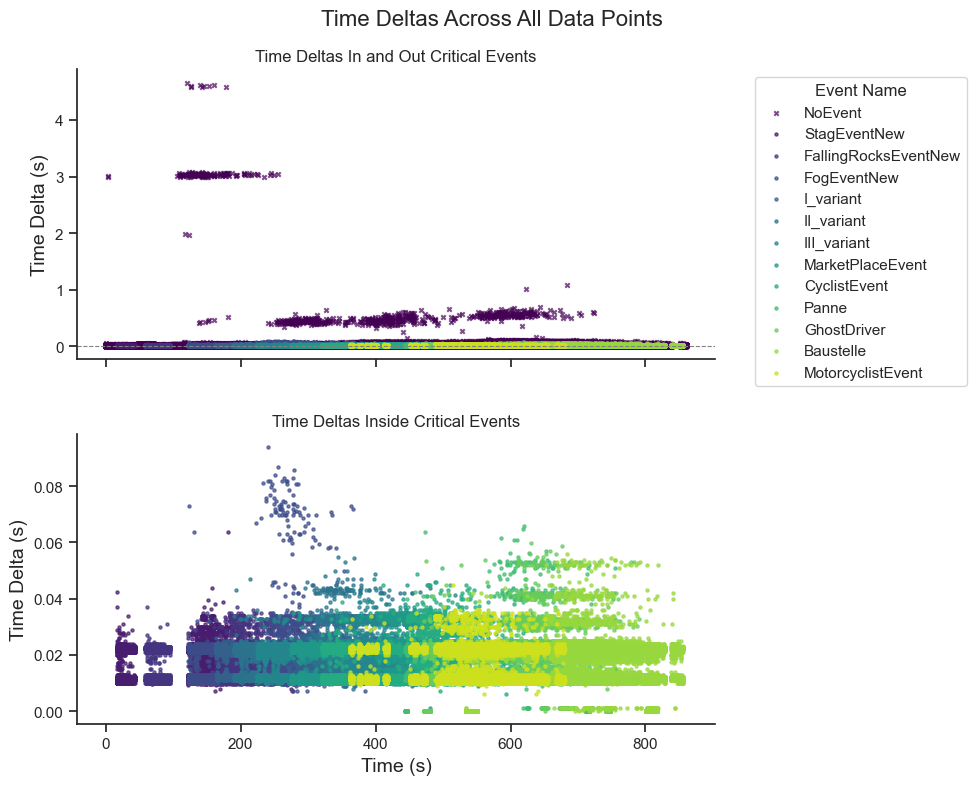

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming filtered_df is your DataFrame that contains 'TimeStamp_in_sec', 'TimeDiff_in_sec', and 'EventName'

# Create a color map based on unique EventNames
unique_events = filtered_df['EventName'].unique()
colors = plt.colormaps['viridis']  # Updated way to get the colormap
num_events = len(unique_events)

# Create a figure for the scatter plot
fig, ax = plt.subplots(2,1,figsize=(10, 8), sharex=True)
fig.suptitle('Time Deltas Across All Data Points', fontsize=16)
# Scatter plot, we will map colors based on EventName
for i, event in enumerate(unique_events):
    marker='o'
    s = 5
    if event == 'NoEvent':
        marker='x'
        s = 10
    event_data = filtered_df[filtered_df['EventName'] == event]
    ax[0].scatter(event_data['TimeStamp_in_sec'], 
                event_data['TimeDiff_in_sec'], 
                color=colors(i / num_events),  # Normalize index to [0, 1] for colormap
                label=event, 
                s=s,  # Marker size
                marker = marker,
                alpha=0.7)  # Transparency
    if event != 'NoEvent':
         ax[1].scatter(event_data['TimeStamp_in_sec'], 
                event_data['TimeDiff_in_sec'], 
                color=colors(i / num_events),  # Normalize index to [0, 1] for colormap
                label=event, 
                s=5,  # Marker size
                alpha=0.7)  # Transparency

# Adding titles and labels

ax[0].set_ylabel('Time Delta (s)', fontsize=14)
ax[0].set_title('Time Deltas In and Out Critical Events')
ax[1].set_xlabel('Time (s)', fontsize=14)
ax[1].set_ylabel('Time Delta (s)', fontsize=14)
ax[1].set_title('Time Deltas Inside Critical Events')
# Adding a horizontal line at y=0 for reference (optional)
ax[0].axhline(0, color='grey', linestyle='--', linewidth=0.8)

# Display the legend
ax[0].legend(title='Event Name', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
# Show the plot
plt.tight_layout()  # Adjust layout to fit labels and title
# plt.savefig(f"plots/delta_time.jpeg", dpi=500, bbox_inches='tight')
# plt.savefig(f"plots/delta_time.pdf", dpi=1200, bbox_inches='tight')
plt.show()

### 1.4 Excluding `II_variant`
We excluded this event because it was particularly complicated across participants

In [13]:
filtered_df = filtered_df[filtered_df['EventName'] != 'II_variant']
print(f"There are {len(filtered_df['EventName'].unique())} events, including {filtered_df['EventName'].unique().tolist()}")

There are 12 events, including ['NoEvent', 'StagEventNew', 'FallingRocksEventNew', 'FogEventNew', 'I_variant', 'III_variant', 'MarketPlaceEvent', 'CyclistEvent', 'Panne', 'GhostDriver', 'Baustelle', 'MotorcyclistEvent']


## 2. Detecting eye blinks
This step we will perform in original dataset with original sampling rate. 
<p> ⚠️Note: <span style="color:orange"> Needs to generalize into a function for all participants.</p>


### 2.1 Label blinks

In [14]:
# Create a condition to detect blinks
# A blink is defined as any entry with all eye position coordinates equal to zero
filtered_df['Blink'] = (filtered_df['EyePosLocalCombined.x'] == 0) & \
                       (filtered_df['EyePosLocalCombined.y'] == 0) & \
                       (filtered_df['EyePosLocalCombined.z'] == 0)

In [15]:
filtered_df.tail(10)

,timestamp_REF,uid,dataset,city_section,ExperimentalCondition,UnixTimeStamp,TobiiTimeStamp,FPS,RightEyeIsBlinkingWorld,RightEyeIsBlinkingLocal,...,SuccessfulCompletionState,HitObjectName,TimeStamp,ReceivedInput,SteeringInput,AcellerationInput,BrakeInput,TimeStamp_in_sec,TimeDiff_in_sec,Blink
100072,2020-09-19 10:31:34.995785216+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.814453,89.869049,False,False,...,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.217672,0.021940,False
100073,2020-09-19 10:31:35.017726464+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.836548,89.970245,False,False,...,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.239614,0.021941,False
100074,2020-09-19 10:31:35.040190720+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.858887,89.829788,False,False,...,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.262078,0.022464,False
100075,2020-09-19 10:31:35.062131968+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.880737,90.124176,False,False,...,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.284019,0.021941,False
100076,2020-09-19 10:31:35.073102592+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.891968,90.020653,False,False,...,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.294990,0.010971,False
100077,2020-09-19 10:31:35.095044608+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.914185,90.083817,False,False,...,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.316932,0.021942,False
100078,2020-09-19 10:31:35.116986112+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.936523,89.880363,False,False,...,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.338873,0.021942,False
100079,2020-09-19 10:31:35.139722752+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.958374,90.203796,False,False,...,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.361610,0.022737,False
100080,2020-09-19 10:31:35.150694400+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.969727,89.948059,False,False,...,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.372582,0.010972,False
100081,2020-09-19 10:31:35.172635904+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,1277.991943,89.988075,False,False,...,NaN,NaN,1.600511e+09,True,-0.007354,0.0,0.0,730.394523,0.021942,False


### 2.2 Calculate blink durations

In [66]:
# unique_uids = filtered_df["uid"].unique()
# # Convert to DataFrame
# unique_uids_df = pd.DataFrame(unique_uids, columns=["uid"])
# 
# # Sample 4 random UIDs
# sampled_uids = unique_uids_df.sample(n=2)["uid"].tolist()
# print(f"Working with {sampled_uids}")
# df = filtered_df[(filtered_df['uid'].isin(sampled_uids))]
# df

In [67]:
# Initialize an empty DataFrame to store all participants' blink durations
blinks_df = pd.DataFrame()

# Initialize a column to hold blink duration information
filtered_df['BlinkDuration'] = np.nan

# Calculate blink durations for each uid
for uid in filtered_df['uid'].unique():
    # Filter uid subset
    df_uid = filtered_df[filtered_df['uid'] == uid] 
    # Identify where blinks start and end
    blink_starts = df_uid['Blink'] & ~df_uid['Blink'].shift(1).fillna(False)  # Blink starts
    blink_ends = df_uid['Blink'] & ~df_uid['Blink'].shift(-1).fillna(False)   # Blink ends

    # Calculate the durations
    blink_times = df_uid[blink_starts]['TimeStamp_in_sec']
    durations = df_uid[blink_ends]['TimeStamp_in_sec'].reset_index(drop=True) - blink_times.reset_index(drop=True)

    # Update the BlinkDuration column to contain durations at blink start in the DataFrame
    for start_index, duration in zip(blink_times.index, durations):
        df_uid.at[start_index, 'BlinkDuration'] = duration
    
    # Store uid data in blinks_df
    blinks_df = pd.concat([blinks_df, df_uid], ignore_index=True)

In [68]:
# Filter the DataFrame to retain only the rows where blinks occurred
blink_durations_df = blinks_df[blinks_df['BlinkDuration'] > 0]
blink_durations_df

,timestamp_REF,uid,dataset,city_section,ExperimentalCondition,UnixTimeStamp,TobiiTimeStamp,FPS,RightEyeIsBlinkingWorld,RightEyeIsBlinkingLocal,...,HitObjectName,TimeStamp,ReceivedInput,SteeringInput,AcellerationInput,BrakeInput,TimeStamp_in_sec,TimeDiff_in_sec,Blink,BlinkDuration
219,2020-09-26 13:46:14.024678656+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,0.0,87.971024,False,False,...,NaN,1.601128e+09,True,-0.005491,0.0,0.0,131.522310,0.022938,True,0.073803
279,2020-09-26 13:46:15.075250688+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,0.0,89.866661,False,False,...,NaN,1.601128e+09,True,-0.005949,0.0,0.0,132.572882,0.010969,True,0.133643
500,2020-09-26 13:46:18.886145792+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,0.0,90.122238,False,False,...,NaN,1.601128e+09,True,-0.005032,0.0,0.0,136.383778,0.022939,True,0.121675
904,2020-09-26 13:46:26.004504832+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,0.0,90.355247,False,False,...,NaN,1.601128e+09,True,0.252965,0.0,0.0,143.502137,0.022939,True,0.088763
1015,2020-09-26 13:46:28.014270976+00:00,0037b2329de444c18d751b4e79901b39,EyeTracking,MountainRoad,BaseCondition,1.601128e+09,0.0,90.128319,False,False,...,StagWithRB,1.601128e+09,True,-0.051466,0.0,0.0,145.511903,0.021943,True,0.111700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5166985,2020-09-19 10:31:13.795443968+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,0.0,88.659576,False,False,...,NaN,1.600511e+09,False,0.000000,0.0,0.0,709.017331,0.022938,True,0.143616
5167200,2020-09-19 10:31:17.559305216+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,0.0,85.059494,False,False,...,NaN,1.600511e+09,True,0.002252,0.0,0.0,712.781192,0.021941,True,0.055851
5167401,2020-09-19 10:31:21.090524160+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,0.0,90.091698,False,False,...,NaN,1.600511e+09,True,0.000389,0.0,0.0,716.312411,0.010971,True,0.100730
5167501,2020-09-19 10:31:22.901095168+00:00,ff4288f304e74bbf93aa6508c7df8145,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,0.0,90.255493,False,False,...,NaN,1.600511e+09,True,-0.017527,0.0,0.0,718.122982,0.021941,True,0.155584


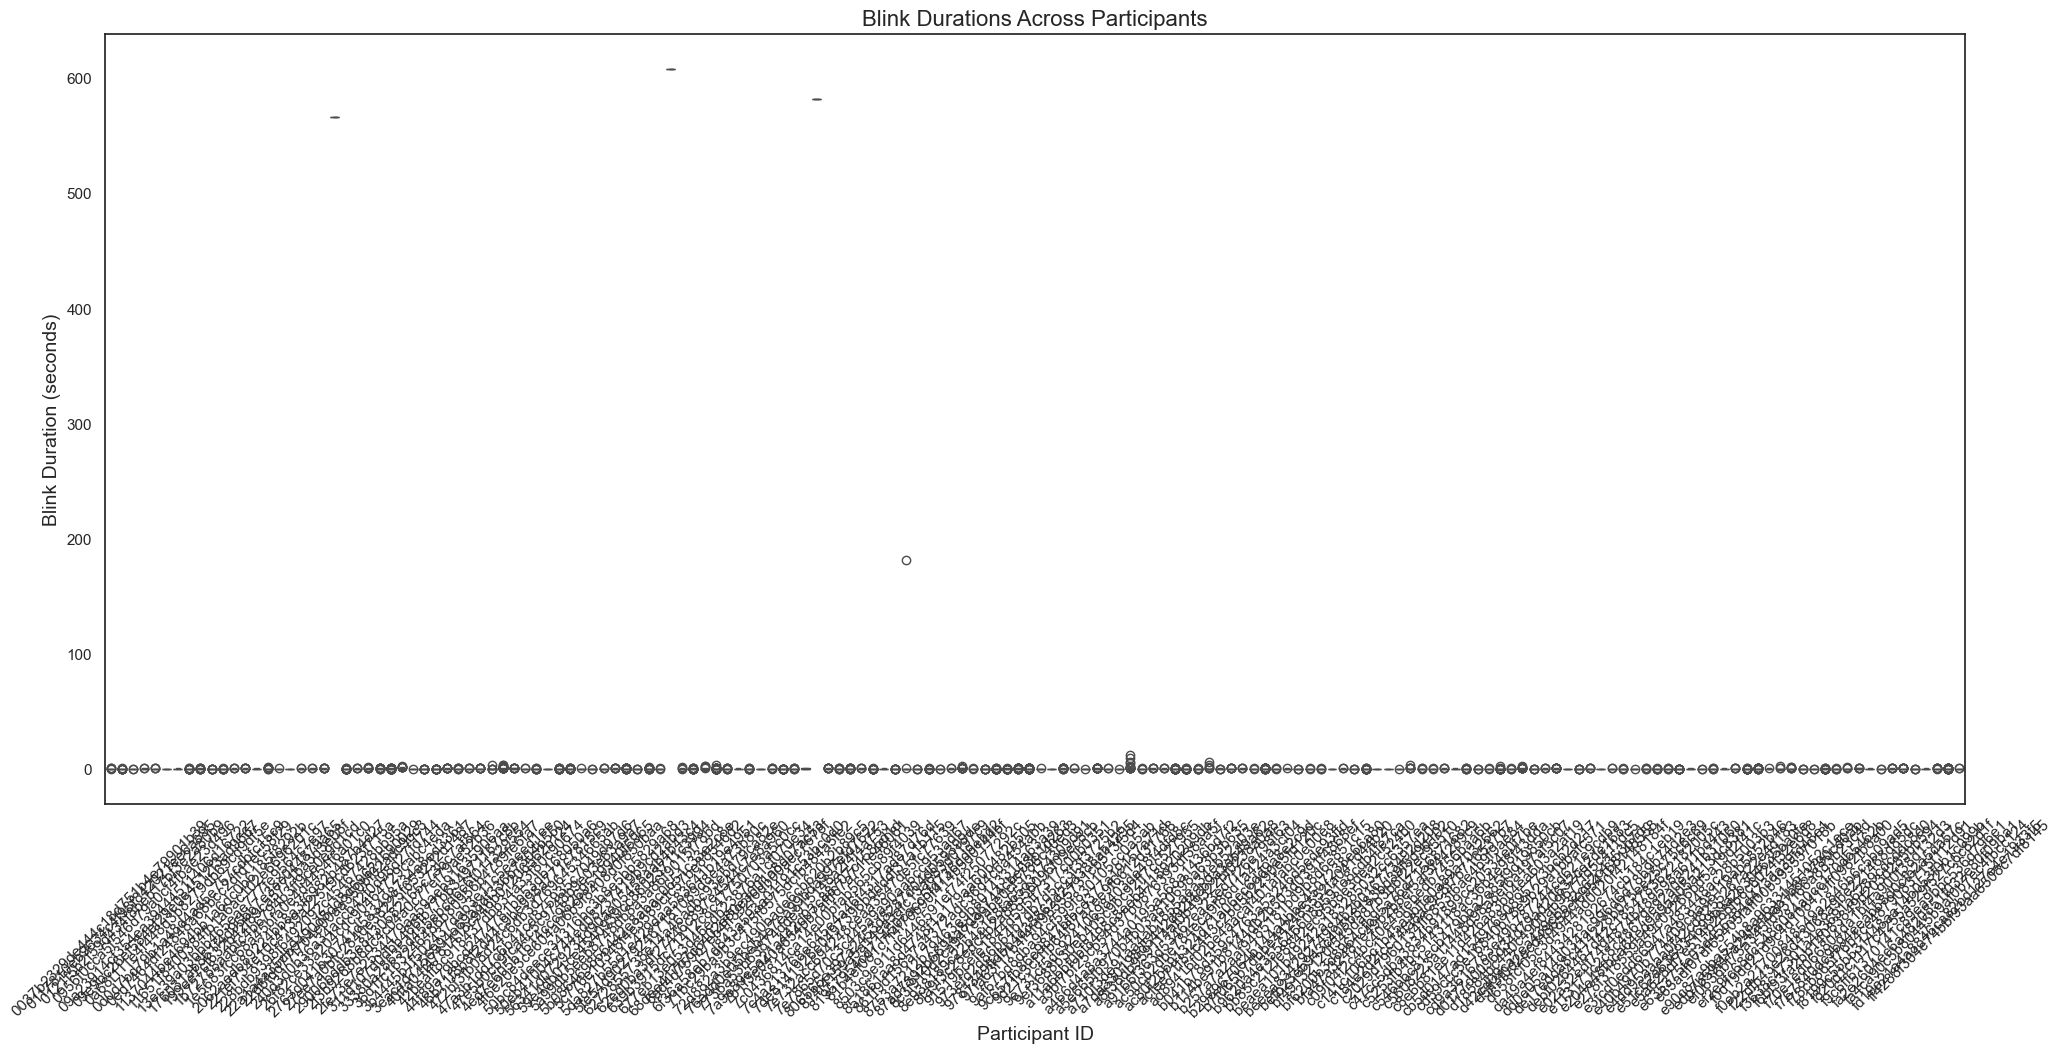

In [84]:
# Set the visual style
sns.set(style="white")

# Create a boxplot for blink durations across participants
fig, ax = plt.subplots(figsize=(24,10))
sns.boxplot(x='uid', y='BlinkDuration', data=blink_durations_df)

# Add title and labels
plt.title('Blink Durations Across Participants', fontsize=16)
plt.xlabel('Participant ID', fontsize=14)
plt.ylabel('Blink Duration (seconds)', fontsize=14)
plt.xticks(rotation=45)
plt.show()

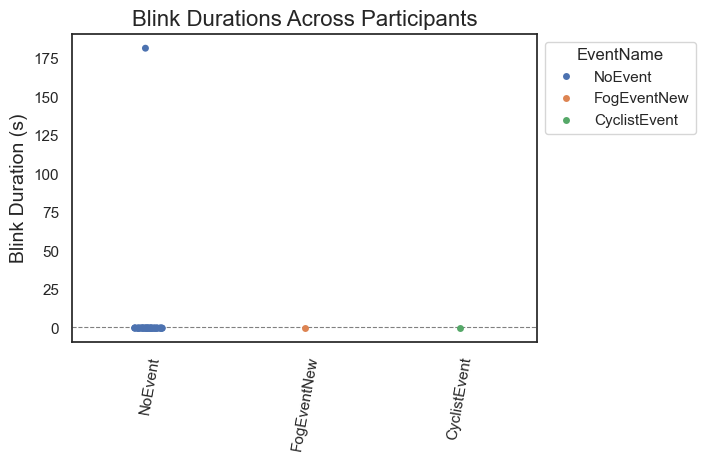

In [97]:
# Set the visual style
sns.set(style="white")
# Create a boxplot for blink durations across participants
# plt.figure(figsize=(12, 6))
fig, ax = plt.subplots(figsize=(6,4))
sns.stripplot(x='EventName', y='BlinkDuration', data=blink_durations_df[blink_durations_df['uid']=='81957954cd71450cacc5fd738dd9ebd2'], hue='EventName',legend=True)
# Add title and labels
plt.title('Blink Durations Across Participants', fontsize=16)
plt.xlabel('', fontsize=14)
plt.ylabel('Blink Duration (s)', fontsize=14)
plt.xticks(rotation=80)
ax.axhline(1, color='grey', linestyle='--', linewidth=0.8)
sns.move_legend(ax,  "upper left", bbox_to_anchor=(1, 1))
# plt.savefig(f"Plots/blink_durations_across_participants" +'.jpeg', dpi=500, bbox_inches='tight')
plt.show()

In [72]:
# Group by uid and count the total blinks 
blink_durations_summary = blink_durations_df.groupby(['uid','EventName'])['BlinkDuration'].count().reset_index()
blink_durations_summary

,uid,EventName,BlinkDuration
0,0037b2329de444c18d751b4e79901b39,Baustelle,3
1,0037b2329de444c18d751b4e79901b39,CyclistEvent,2
2,0037b2329de444c18d751b4e79901b39,FallingRocksEventNew,1
3,0037b2329de444c18d751b4e79901b39,GhostDriver,1
4,0037b2329de444c18d751b4e79901b39,I_variant,1
...,...,...,...
1040,ff4288f304e74bbf93aa6508c7df8145,Baustelle,1
1041,ff4288f304e74bbf93aa6508c7df8145,GhostDriver,1
1042,ff4288f304e74bbf93aa6508c7df8145,I_variant,1
1043,ff4288f304e74bbf93aa6508c7df8145,NoEvent,100


In [110]:
blink_durations_df[blink_durations_df['BlinkDuration'] > 10]

,timestamp_REF,uid,dataset,city_section,ExperimentalCondition,UnixTimeStamp,TobiiTimeStamp,FPS,RightEyeIsBlinkingWorld,RightEyeIsBlinkingLocal,...,HitObjectName,TimeStamp,ReceivedInput,SteeringInput,AcellerationInput,BrakeInput,TimeStamp_in_sec,TimeDiff_in_sec,Blink,BlinkDuration
613515,2020-11-27 11:48:47.197136640+00:00,22d6fdd77f704e00aa350bf02adc9bc3,EyeTracking,MountainRoad,BaseCondition,1.606478e+09,738.968506,90.238945,False,False,...,NaN,1.606478e+09,True,0.041141,0.0,0.0,257.325680,NaN,True,566.508119
1543517,2020-10-20 07:12:59.042854400+00:00,5fe54d902792467181089d8e4a73b80c,EyeTracking,MountainRoad,HUDOnly,1.603178e+09,913.174011,87.137024,False,False,...,NaN,1.603178e+09,True,-0.072209,0.0,0.0,149.891958,NaN,True,608.189089
1948535,2020-10-21 07:34:19.164723200+00:00,7b1f3e040a654bb7afff67a711e46081,EyeTracking,MountainRoad,HUDOnly,1.603266e+09,456.305481,90.032639,False,False,...,NaN,1.603266e+09,True,-0.018474,0.0,0.0,141.644706,NaN,True,582.040724
2224798,2020-10-15 09:19:47.923995392+00:00,81957954cd71450cacc5fd738dd9ebd2,EyeTracking,CountryRoad,BaseCondition,1.602754e+09,0.000000,89.926857,False,False,...,NaN,1.602754e+09,True,-0.025866,0.0,0.0,624.184447,0.022939,True,181.661404
2853699,2020-09-19 10:29:34.002650112+00:00,a3bf7bf25cb54d37b0876393df38aa5f,EyeTracking,Autobahn,FullLoopAR,1.600511e+09,0.000000,85.589661,False,False,...,NaN,1.600511e+09,True,0.073125,0.0,0.0,635.368358,0.022905,True,12.373268


In [3]:
# Visually inspect > 100 s blink durations suggesting recording issues
blinks_df[blinks_df['uid'] == 'a3bf7bf25cb54d37b0876393df38aa5f']

NameError: name 'blinks_df' is not defined

### 2.3 Excluded UIDs 
* `22d6fdd77f704e00aa350bf02adc9bc3` recording issues for EyeLocal variables for the entire experiment duration, there is still data for EyeWorld
* `5fe54d902792467181089d8e4a73b80c` recording issues for EyeLocal variables for the entire experiment duration, there is still data for EyeWorld
* `7b1f3e040a654bb7afff67a711e46081` recording issues for EyeLocal variables for the entire experiment duration, there is still data for EyeWorld
* `81957954cd71450cacc5fd738dd9ebd2` one instance of recording issues outside event (duration = 181.6 s)

In [2]:
one_excluded = blinks_df[(blinks_df['uid'] == 'a3bf7bf25cb54d37b0876393df38aa5f') &(blinks_df['Blink'] == True)]

NameError: name 'blinks_df' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(26,8))
sns.lineplot(x='TimeStamp_in_sec', y='EyeDirLocalCombined.y', 
                data=one_excluded, hue='Blink', size=50, legend=True)

## 5. Later steps:
While applying Blink detection and interpolate short durations and exclude long durations (Literature to support > 500ms)